In [1]:
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import torch
from torch import Tensor
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Optimizer, Adam
from pytorch_lightning import Trainer
from scipy.stats import multivariate_normal, sem
from sklearn.linear_model import BayesianRidge

from experiments.linear_regression_posterior import compute_true_posterior
from experiments.utils.metrics import compute_distance_between_matrices, compute_gaussian_wasserstein_distance
from swafa.models import FeedForwardNet
from swafa.callbacks import FactorAnalysisVariationalInferenceCallback

np.set_printoptions(suppress=True) # don't use scientific notation

%load_ext autoreload
%autoreload 2

### Define parameters

In [18]:
# data
n_samples, n_features = 1000, 2
feature_covar = [
    [1, 0.5], 
    [0.5, 1]
]
alpha = 0.01
beta = 0.1

# callbacks
latent_dim = 2
n_gradients_per_update = 1
optimiser_class = SGD
bias_optimiser_kwargs = dict(lr=1e-2)
factors_optimiser_kwargs = dict(lr=1e-4)
noise_optimiser_kwargs = dict(lr=1e-2)

# training
batch_size = 100
n_epochs = 2000

### Define helper functions

In [6]:
def run_experiment(n_samples: int, n_features: int, feature_covar: np.ndarray, alpha: float, beta: float, 
                   latent_dim: int, n_gradients_per_update: int, optimiser_class: Optimizer,
                   bias_optimiser_kwargs: dict, factors_optimiser_kwargs: dict, noise_optimiser_kwargs: int,
                   n_epochs: int, batch_size: int, n_trials: int) -> (List[float], List[float], List[float]):
    
    relative_distances_from_mean = []
    relative_distances_from_cov = []
    wasserstein_distances = []
    for n in range(n_trials):
        true_posterior_mean, true_posterior_covar, variational_mean, variational_covar, _ = run_trial(
            n_samples=n_samples, 
            n_features=n_features, 
            feature_covar=feature_covar, 
            alpha=alpha, 
            beta=beta, 
            latent_dim=latent_dim, 
            n_gradients_per_update=n_gradients_per_update,
            optimiser_class=optimiser_class,
            bias_optimiser_kwargs=bias_optimiser_kwargs,
            factors_optimiser_kwargs=factors_optimiser_kwargs,
            noise_optimiser_kwargs=noise_optimiser_kwargs,
            n_epochs=n_epochs,
            batch_size=batch_size, 
            random_seed=n
        )
        
        relative_distances_from_mean.append(
            compute_distance_between_matrices(
                true_posterior_mean, 
                variational_mean,
            ) /
            compute_distance_between_matrices(
                true_posterior_mean, 
                torch.zeros_like(true_posterior_mean),
            )
        )
        
        relative_distances_from_cov.append(
            compute_distance_between_matrices(
                true_posterior_covar, 
                variational_covar,
            ) /
            compute_distance_between_matrices(
                true_posterior_covar, 
                torch.zeros_like(true_posterior_covar),
            )
        )
        
        wasserstein_distances.append(
            compute_gaussian_wasserstein_distance(
                mean1=true_posterior_mean, 
                covar1=true_posterior_covar, 
                mean2=variational_mean, 
                covar2=variational_covar,
            )
        )
        
    return relative_distances_from_mean, relative_distances_from_cov, wasserstein_distances


def run_trial(n_samples: int, n_features: int, feature_covar: np.ndarray, alpha: float, beta: float, 
              latent_dim: int, n_gradients_per_update: int, optimiser_class: Optimizer,
              bias_optimiser_kwargs: dict, factors_optimiser_kwargs: dict, noise_optimiser_kwargs: int,
              n_epochs: int, batch_size: int, random_seed: int,
             ) -> (Tensor, Tensor, Tensor, Tensor, FactorAnalysisVariationalInferenceCallback):
    X, y = generate_data(n_samples, n_features, feature_covar, beta, random_seed)
    
    true_posterior_mean, true_posterior_covar, _, _ = compute_true_posterior(
        X, y, alpha=alpha, beta=beta
    )
    
    model = FeedForwardNet(
        input_dim=n_features, 
        bias=False, 
        optimiser_class=optimiser_class, 
        optimiser_kwargs=bias_optimiser_kwargs,
    )
    
    callback = FactorAnalysisVariationalInferenceCallback(
        latent_dim, 
        precision=alpha, 
        n_gradients_per_update=n_gradients_per_update, 
        optimiser_class=optimiser_class, 
        bias_optimiser_kwargs=bias_optimiser_kwargs,
        factors_optimiser_kwargs=factors_optimiser_kwargs,
        noise_optimiser_kwargs=noise_optimiser_kwargs,
        random_seed=random_seed
    )
    
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

    trainer = Trainer(
        max_epochs=n_epochs, callbacks=callback, progress_bar_refresh_rate=0,
    )
    trainer.fit(model, train_dataloader=dataloader)
    
    variational_mean = callback.get_variational_mean()
    variational_covar = callback.get_variational_covariance()
    
    return true_posterior_mean, true_posterior_covar, variational_mean, variational_covar, callback

    
def generate_data(n_samples: int, n_features: int, feature_covar: np.ndarray, beta: float, random_seed: int,
                  ) -> (np.ndarray, np.ndarray):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    p_x = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.Tensor(feature_covar))
    X = p_x.sample((n_samples,))

    p_theta = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.eye(n_features) / alpha)
    theta = p_theta.sample().reshape(-1, 1)

    epsilon = torch.normal(torch.zeros(n_samples), (1 / np.sqrt(beta)) * torch.ones(n_samples))
    y = X.mm(theta).squeeze() + epsilon
    
    return X, y

### Run experiment

In [7]:
relative_distances_from_mean, relative_distances_from_cov, wasserstein_distances = run_experiment(
    n_samples=n_samples, 
    n_features=n_features, 
    feature_covar=feature_covar, 
    alpha=alpha, 
    beta=beta, 
    latent_dim=latent_dim, 
    n_gradients_per_update=n_gradients_per_update,
    optimiser_class=optimiser_class,
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    n_epochs=n_epochs,
    batch_size=batch_size, 
    n_trials=10
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')

  | Name          | Type       | Params
---------------------------------------------
0 | loss_fn       | MSELoss    | 0     
1 | hidden_layers | ModuleList | 0     
2 | output_layer  | Linear     | 2     
---------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increa

In [8]:
relative_distances_from_mean_mean = np.mean(relative_distances_from_mean)
relative_distances_from_mean_std_error = sem(relative_distances_from_mean)

relative_distances_from_cov_mean = np.mean(relative_distances_from_cov)
relative_distances_from_cov_std_error = sem(relative_distances_from_cov)

wasserstein_mean = np.mean(wasserstein_distances)
wasserstein_std_error = sem(wasserstein_distances)

print('Mean Relative Distance from Mean = {:.4f} +- {:.4f}'.format(
    relative_distances_from_mean_mean, relative_distances_from_mean_std_error,
))

print('Mean Relative Distance from Covar = {:.4f} +- {:.4f}'.format(
    relative_distances_from_cov_mean, relative_distances_from_cov_std_error,
))

print('Mean Wasserstein Distance = {:.4f} +- {:.4f}'.format(
    wasserstein_mean, wasserstein_std_error,
))

Mean Relative Distance from Mean = 0.0072 +- 0.0010
Mean Relative Distance from Covar = 0.2055 +- 0.0369
Mean Wasserstein Distance = 0.0162 +- 0.0063


### Plot distributions for a single trial

In [19]:
true_posterior_mean, true_posterior_covar, variational_mean, variational_covar, callback = run_trial(
    n_samples=n_samples, 
    n_features=n_features, 
    feature_covar=feature_covar, 
    alpha=alpha, 
    beta=beta, 
    latent_dim=latent_dim, 
    n_gradients_per_update=n_gradients_per_update,
    optimiser_class=optimiser_class,
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    n_epochs=n_epochs,
    batch_size=batch_size, 
    random_seed=1
)


true_posterior_mean = true_posterior_mean.numpy()
true_posterior_covar = true_posterior_covar.numpy()
variational_mean = variational_mean.numpy()
variational_covar = variational_covar.numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | loss_fn       | MSELoss    | 0     
1 | hidden_layers | ModuleList | 0     
2 | output_layer  | Linear     | 2     
---------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


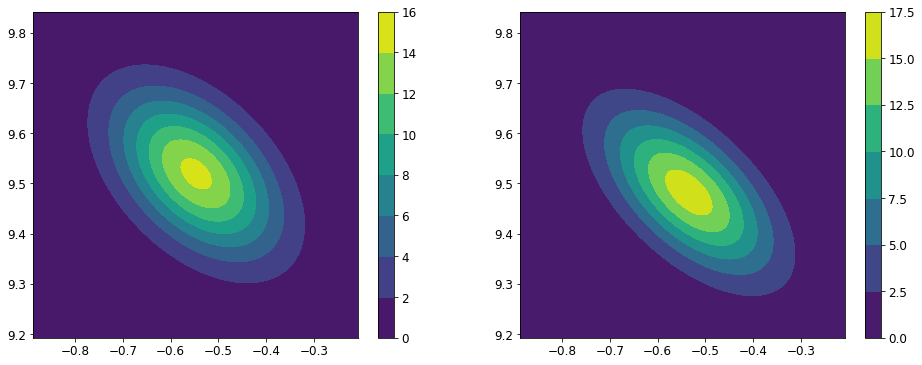

In [20]:
def plot_pdf(mean: np.ndarray, covar: np.ndarray, ax: Axes, x_grid: np.ndarray = None, y_grid: np.ndarray = None):
    plt.rcParams.update({'font.size': 12})
    
    if x_grid is None:
        x_std3 = np.sqrt(covar[0, 0]) * 3
        x_min = mean[0] - x_std3
        x_max = mean[0] + x_std3

        y_std3 = np.sqrt(covar[1, 1]) * 3
        y_min = mean[1] - y_std3
        y_max = mean[1] + y_std3

        x_grid, y_grid = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
        
    pos = np.dstack((x_grid, y_grid))
    rv = multivariate_normal(mean, covar)
    c = ax.contourf(x_grid, y_grid, rv.pdf(pos))
    plt.colorbar(c, ax=ax)
    
    return x_grid, y_grid
    

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_grid, y_grid = plot_pdf(true_posterior_mean, true_posterior_covar, axes[0])
plot_pdf(variational_mean, variational_covar, axes[1], x_grid, y_grid)

png_path = f'../../thesis/plots/linear_model_vi_posterior__latent_dim={latent_dim}.png'
plt.savefig(png_path, format='png')

plt.show()



In [94]:
# from typing import Dict, List, Optional, Tuple
# from copy import deepcopy

# import torch
# import torch.nn as nn
# from torch import Tensor
# from torch.optim import Optimizer, Adam
# from pytorch_lightning import LightningModule


# class GaussianNet(LightningModule):

#     def __init__(self, input_dim: int, hidden_dims: Optional[List[int]] = None,
#                  hidden_activation_fn: Optional[nn.Module] = None, bias: bool = True, 
#                  optimiser_class: Optimizer = Adam, optimiser_kwargs: Optional[dict] = None,
#                  random_seed: Optional[int] = None):
#         super().__init__()
#         if random_seed is not None:
#             torch.manual_seed(random_seed)

#         self.input_dim = input_dim
#         self.hidden_dims = hidden_dims or []
#         self.hidden_activation_fn = hidden_activation_fn or self._identity_fn
#         self.optimiser_class = optimiser_class
#         self.optimiser_kwargs = optimiser_kwargs or dict(lr=1e-3)
#         self.loss_fn = nn.GaussianNLLLoss(eps=1e-2)

#         self.hidden_layers = nn.ModuleList()
#         d_in = deepcopy(input_dim)
#         for d_out in self.hidden_dims:
#             self.hidden_layers.append(nn.Linear(d_in, d_out, bias=bias))
#             d_in = d_out

#         self.mu_layer = nn.Linear(d_in, 1, bias=bias)
#         self.var_layer = nn.Linear(d_in, 1, bias=bias)

#     @staticmethod
#     def _identity_fn(X: Tensor) -> Tensor:
#         return X

#     def forward(self, X: Tensor) -> Tensor:
#         for layer in self.hidden_layers:
#             X = self.hidden_activation_fn(layer(X))

#         mu = self.mu_layer(X).squeeze(dim=1)
#         var = torch.exp(self.var_layer(X).squeeze(dim=1))
        
#         return mu, var

#     def configure_optimizers(self) -> Optimizer:
#         return self.optimiser_class(self.parameters(), **self.optimiser_kwargs)

#     def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
#         return self._step(batch, batch_idx)

#     def validation_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
#         return self._step(batch, batch_idx)

#     def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
#         return self._step(batch, batch_idx)

#     def _step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
#         X, y = batch
#         mu, var = self(X)
#         return self.loss_fn(mu, y, var)

#     def validation_epoch_end(self, step_losses: List[Tensor]) -> Dict[str, Tensor]:
#         loss = self._average_loss(step_losses)
#         metrics = dict(epoch_val_loss=loss)
#         self.log_dict(metrics)
#         return metrics

#     def test_epoch_end(self, step_losses: List[Tensor]) -> Dict[str, Tensor]:
#         loss = self._average_loss(step_losses)
#         metrics = dict(epoch_test_loss=loss)
#         self.log_dict(metrics)
#         return metrics

#     @staticmethod
#     def _average_loss(step_losses: List[Tensor]) -> Tensor:
#         return torch.stack(step_losses).mean()